<a href="https://colab.research.google.com/github/alanchan30/NeuralNetworkAnalyzation/blob/main/Neural_Network_Analyzation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# importing required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [95]:
# Define the neural network architecture
class SimpleANN(nn.Module):
    def __init__(self, hidden_nodes, learning_rate):
        super(SimpleANN, self).__init__()
        self.hidden_nodes = hidden_nodes

        # Network layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_nodes)  # Input layer -> Hidden layer (11 neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_nodes, 10)       # Hidden layer -> Output layer (10 classes)

        # Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        # GLobal lists for storing activations
        self.neuron_activations = []
        self.target_digits = []

    def forward(self, x, return_activations=False):
        x = self.flatten(x)
        x = self.fc1(x)
        activations = self.relu(x)
        output = self.fc2(activations)
        if return_activations:
            return output, activations
        return output

In [96]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
batch_size = 64
epochs = 10

# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # mean and std of MNIST dataset, respectively
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [97]:
# Training loop
def train(model, train_loader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Batch: {batch_idx}/{len(train_loader)} '
                  f'Loss: {loss.item():.4f}')

# Modified testing loop to record activations
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    model.neuron_activations = []
    model.target_digits = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, activations = model(data, return_activations=True)
            test_loss += model.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store activations and corresponding targets
            model.neuron_activations.extend(activations.cpu().numpy())
            model.target_digits.extend(target.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')

In [98]:
# Modified heatmap function
def plot_activation_heatmap(model):
    # Convert lists to numpy arrays
    activations_array = np.array(model.neuron_activations)
    targets_array = np.array(model.target_digits)

    # Scale the activations to [0,1] range
    scaler = MinMaxScaler()
    activations_scaled = scaler.fit_transform(activations_array)

    # Select first 100 samples for visualization
    n_samples = 100
    sample_activations = activations_scaled[:n_samples]
    sample_targets = targets_array[:n_samples]

    # Create heatmap
    plt.figure(figsize=(15, model.hidden_nodes-1))
    plt.imshow(sample_activations, cmap='viridis', aspect='auto')
    plt.colorbar(label='Scaled Activation')
    plt.xlabel('Neuron Index')
    plt.ylabel('Sample Index')
    plt.title('Hidden Layer Neuron Activations per Sample')

    # Add labels
    plt.xticks(range(model.hidden_nodes), range(model.hidden_nodes))

    # Add digit labels on y-axis
    plt.yticks(range(n_samples), [f'Sample {i} (Digit {t})' for i, t in enumerate(sample_targets)],
               fontsize=8)

    plt.tight_layout()
    plt.savefig('neuron_activations_heatmap_per_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

def train_model(model, model_name):
    print(f"Training on device: {device}")
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch: {epoch}")
        train(model, train_loader, model.criterion, model.optimizer)
        test(model, test_loader)

    # Save the model
    torch.save(model.state_dict(), f'mnist_ann_{model_name}.pth')

def load_model_and_evaluate(model, model_name):
    print("Loading model from checkpoint...")
    model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))
    print("Running evaluation...")
    test(model, test_loader)

# Add this new function
def test_with_masked_neurons(model, test_loader, keep_neurons):
    model.eval()
    test_loss = 0
    correct = 0

    # Create a mask for the neurons (1 for keep, 0 for mask)
    neuron_mask = torch.zeros(model.hidden_nodes, device=device)
    neuron_mask[keep_neurons] = 1

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass with masked neurons
            x = model.flatten(data)
            x = model.fc1(x)
            # Apply mask to zero out unwanted neurons
            x = x * neuron_mask
            x = model.relu(x)
            output = model.fc2(x)

            test_loss += model.criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set with only neurons {keep_neurons} active:')
    print(f'Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')

# **TESTING TOP 3 MOST ACTIVATED NODES IN MODELS WITH VARYING NUMBER OF NODES WITHIN THE HIDDEN LAYER**



In [99]:
# Configuration
TRAIN_FROM_SCRATCH = False  # Set to True to train from scratch, False to load from checkpoint

**9 nodes**

Loading model from checkpoint...
Running evaluation...


<ipython-input-98-17ff8814660d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))



Test set: Average loss: 0.2520, Accuracy: 9276/10000 (92.76%)



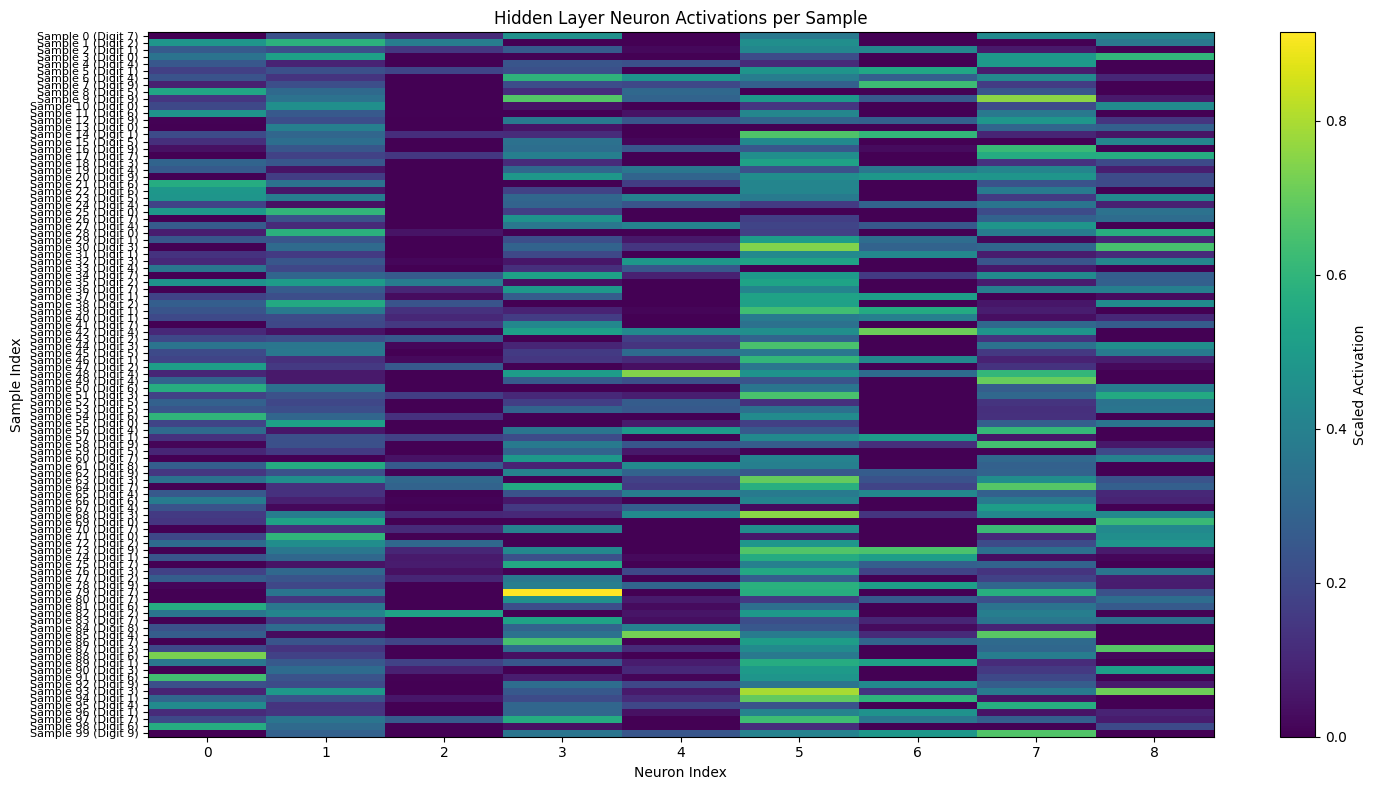


Running evaluation with masked neurons...

Test set with only neurons [0, 5, 7] active:
Average loss: 2.9836, Accuracy: 2830/10000 (28.30%)



In [100]:
# Model with 9 nodes within the hidden layer
model9 = SimpleANN(9, 0.001).to(device)

try:
    if TRAIN_FROM_SCRATCH:
        print("Training new model from scratch...")
        train_model(model9, "9")
    else:
        load_model_and_evaluate(model9, "9")

    # Plot the heatmap after either training or loading
    plot_activation_heatmap(model9)

    # Run evaluation with only neurons X, X, X active
    print("\nRunning evaluation with masked neurons...")
    test_with_masked_neurons(model9, test_loader, keep_neurons=[
        0,
        5,
        7
    ])

except FileNotFoundError:
    print("No checkpoint found! Please train the model first by setting TRAIN_FROM_SCRATCH = True")
except Exception as e:
    print(f"An error occurred: {str(e)}")

**10 nodes**

Loading model from checkpoint...
Running evaluation...


<ipython-input-98-17ff8814660d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))



Test set: Average loss: 0.2523, Accuracy: 9293/10000 (92.93%)



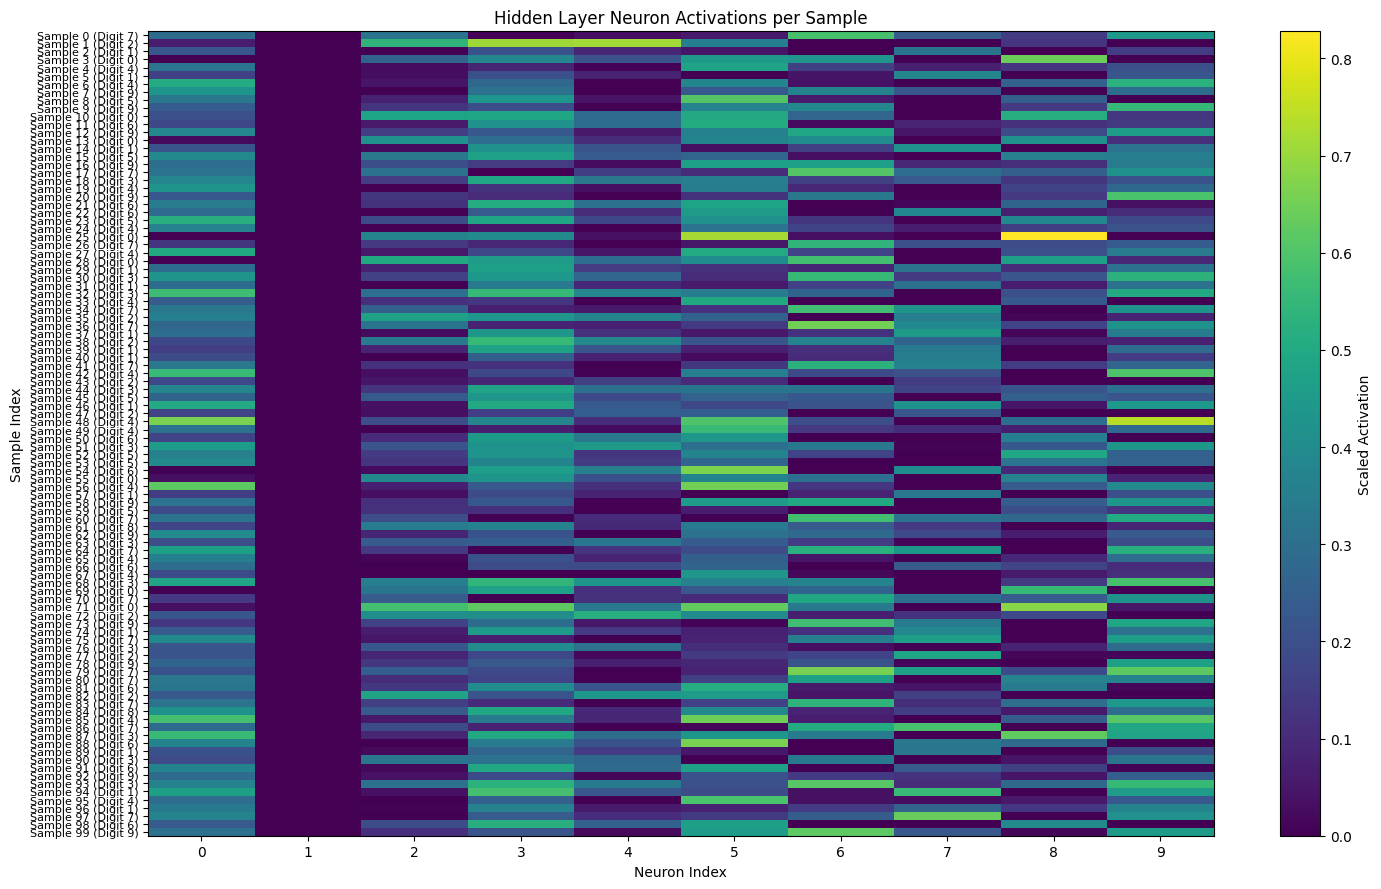


Running evaluation with masked neurons...

Test set with only neurons [0, 3, 5] active:
Average loss: 5.9117, Accuracy: 2162/10000 (21.62%)



In [101]:
# Model with 10 nodes within the hidden layer
model10 = SimpleANN(10, 0.001).to(device)

try:
    if TRAIN_FROM_SCRATCH:
        print("Training new model from scratch...")
        train_model(model10, "10")
    else:
        load_model_and_evaluate(model10, "10")

    # Plot the heatmap after either training or loading
    plot_activation_heatmap(model10)

    # Run evaluation with only neurons X, X, X active
    print("\nRunning evaluation with masked neurons...")
    test_with_masked_neurons(model10, test_loader, keep_neurons=[
        0,
        3,
        5
    ])

except FileNotFoundError:
    print("No checkpoint found! Please train the model first by setting TRAIN_FROM_SCRATCH = True")
except Exception as e:
    print(f"An error occurred: {str(e)}")

**11 nodes**

Loading model from checkpoint...
Running evaluation...


<ipython-input-98-17ff8814660d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))



Test set: Average loss: 0.2145, Accuracy: 9382/10000 (93.82%)



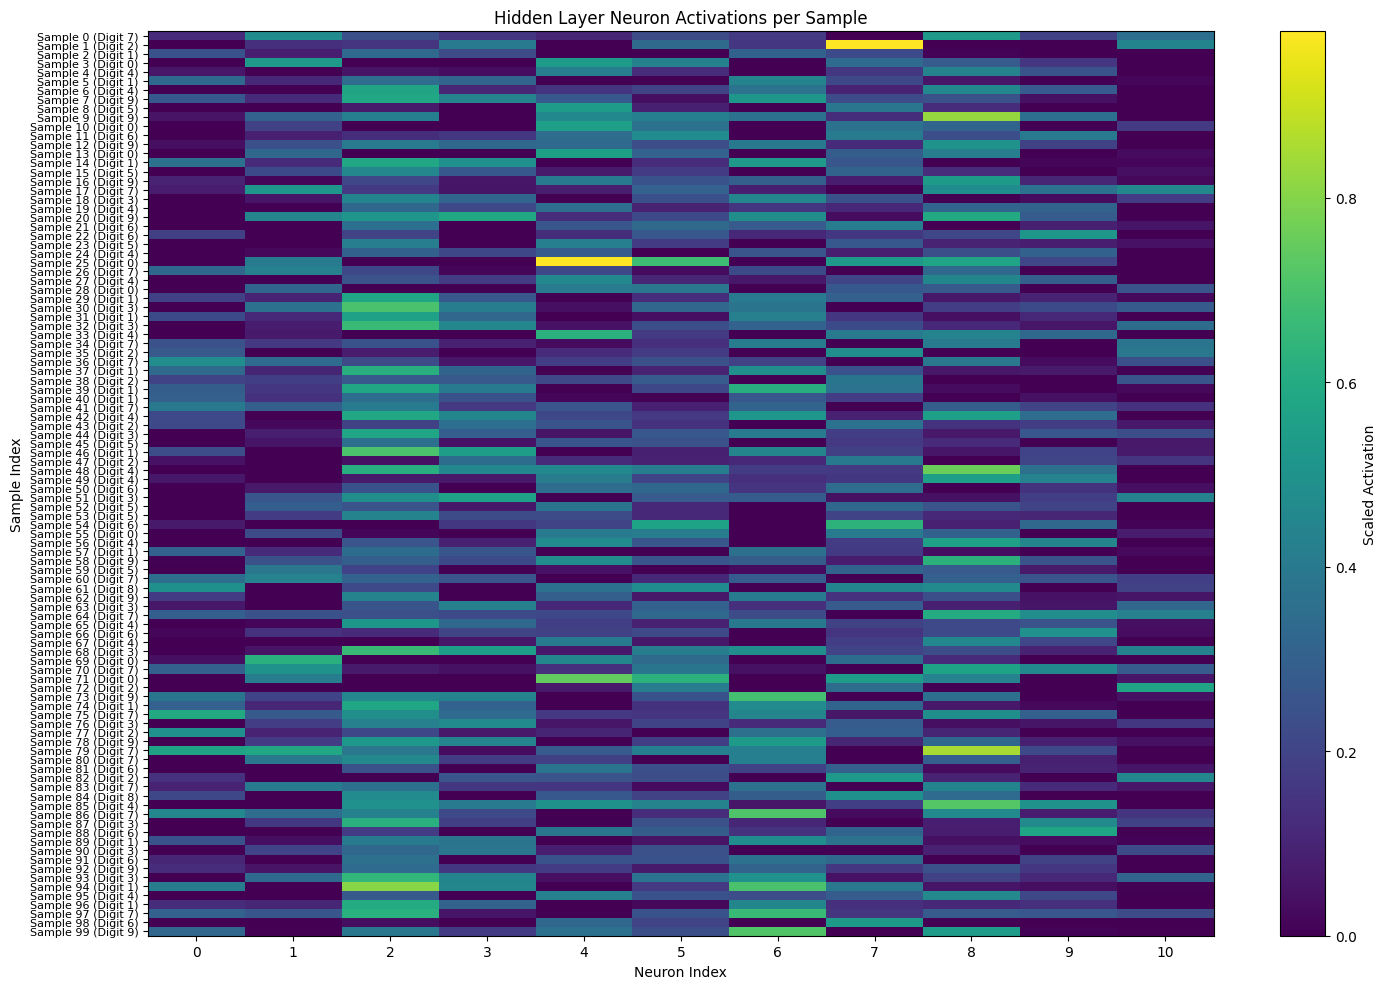


Running evaluation with masked neurons...

Test set with only neurons [2, 4, 7] active:
Average loss: 5.7252, Accuracy: 1251/10000 (12.51%)



In [102]:
# Model with 11 nodes within the hidden layer
model11 = SimpleANN(11, 0.001).to(device)

try:
    if TRAIN_FROM_SCRATCH:
        print("Training new model from scratch...")
        train_model(model11, "11")
    else:
        load_model_and_evaluate(model11, "11")

    # Plot the heatmap after either training or loading
    plot_activation_heatmap(model11)

    # Run evaluation with only neurons X, X, X active
    print("\nRunning evaluation with masked neurons...")
    test_with_masked_neurons(model11, test_loader, keep_neurons=[
        2,
        4,
        7
    ])

except FileNotFoundError:
    print("No checkpoint found! Please train the model first by setting TRAIN_FROM_SCRATCH = True")
except Exception as e:
    print(f"An error occurred: {str(e)}")

**12 nodes**

Loading model from checkpoint...
Running evaluation...


<ipython-input-98-17ff8814660d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))



Test set: Average loss: 0.1979, Accuracy: 9435/10000 (94.35%)



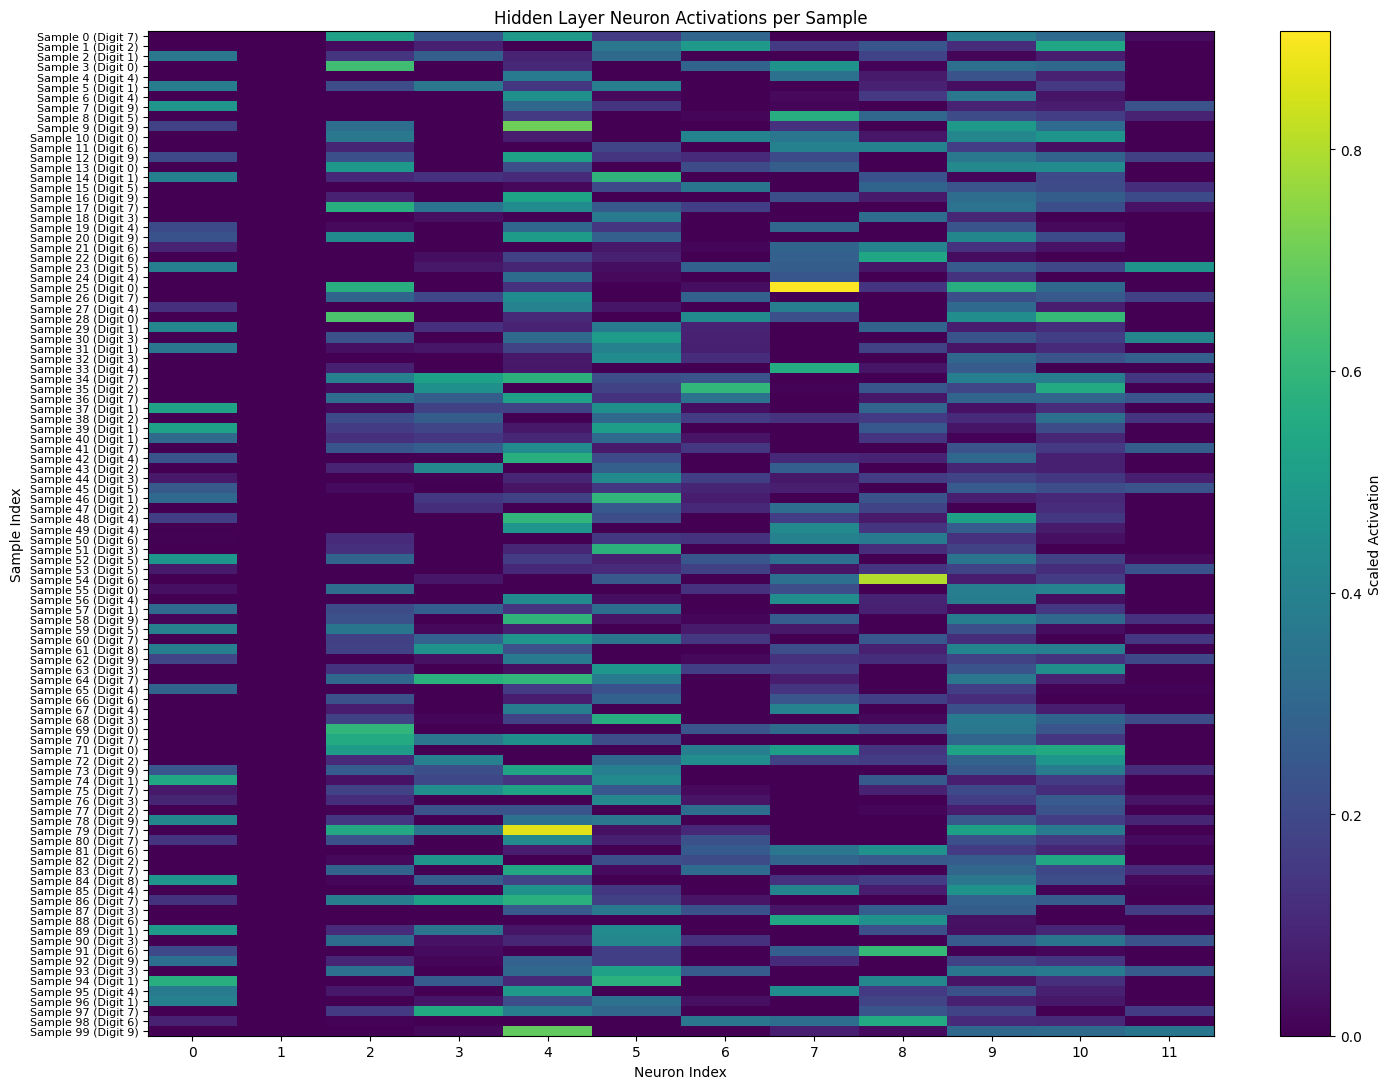


Running evaluation with masked neurons...

Test set with only neurons [4, 5, 9] active:
Average loss: 4.1434, Accuracy: 1741/10000 (17.41%)



In [103]:
# Model with 12 nodes within the hidden layer
model12 = SimpleANN(12, 0.001).to(device)

try:
    if TRAIN_FROM_SCRATCH:
        print("Training new model from scratch...")
        train_model(model12, "12")
    else:
        load_model_and_evaluate(model12, "12")

    # Plot the heatmap after either training or loading
    plot_activation_heatmap(model12)

    # Run evaluation with only neurons X, X, X active
    print("\nRunning evaluation with masked neurons...")
    test_with_masked_neurons(model12, test_loader, keep_neurons=[
        4,
        5,
        9
    ])

except FileNotFoundError:
    print("No checkpoint found! Please train the model first by setting TRAIN_FROM_SCRATCH = True")
except Exception as e:
    print(f"An error occurred: {str(e)}")

**13 nodes**

Loading model from checkpoint...
Running evaluation...


<ipython-input-98-17ff8814660d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'mnist_ann_{model_name}.pth'))



Test set: Average loss: 0.1884, Accuracy: 9460/10000 (94.60%)



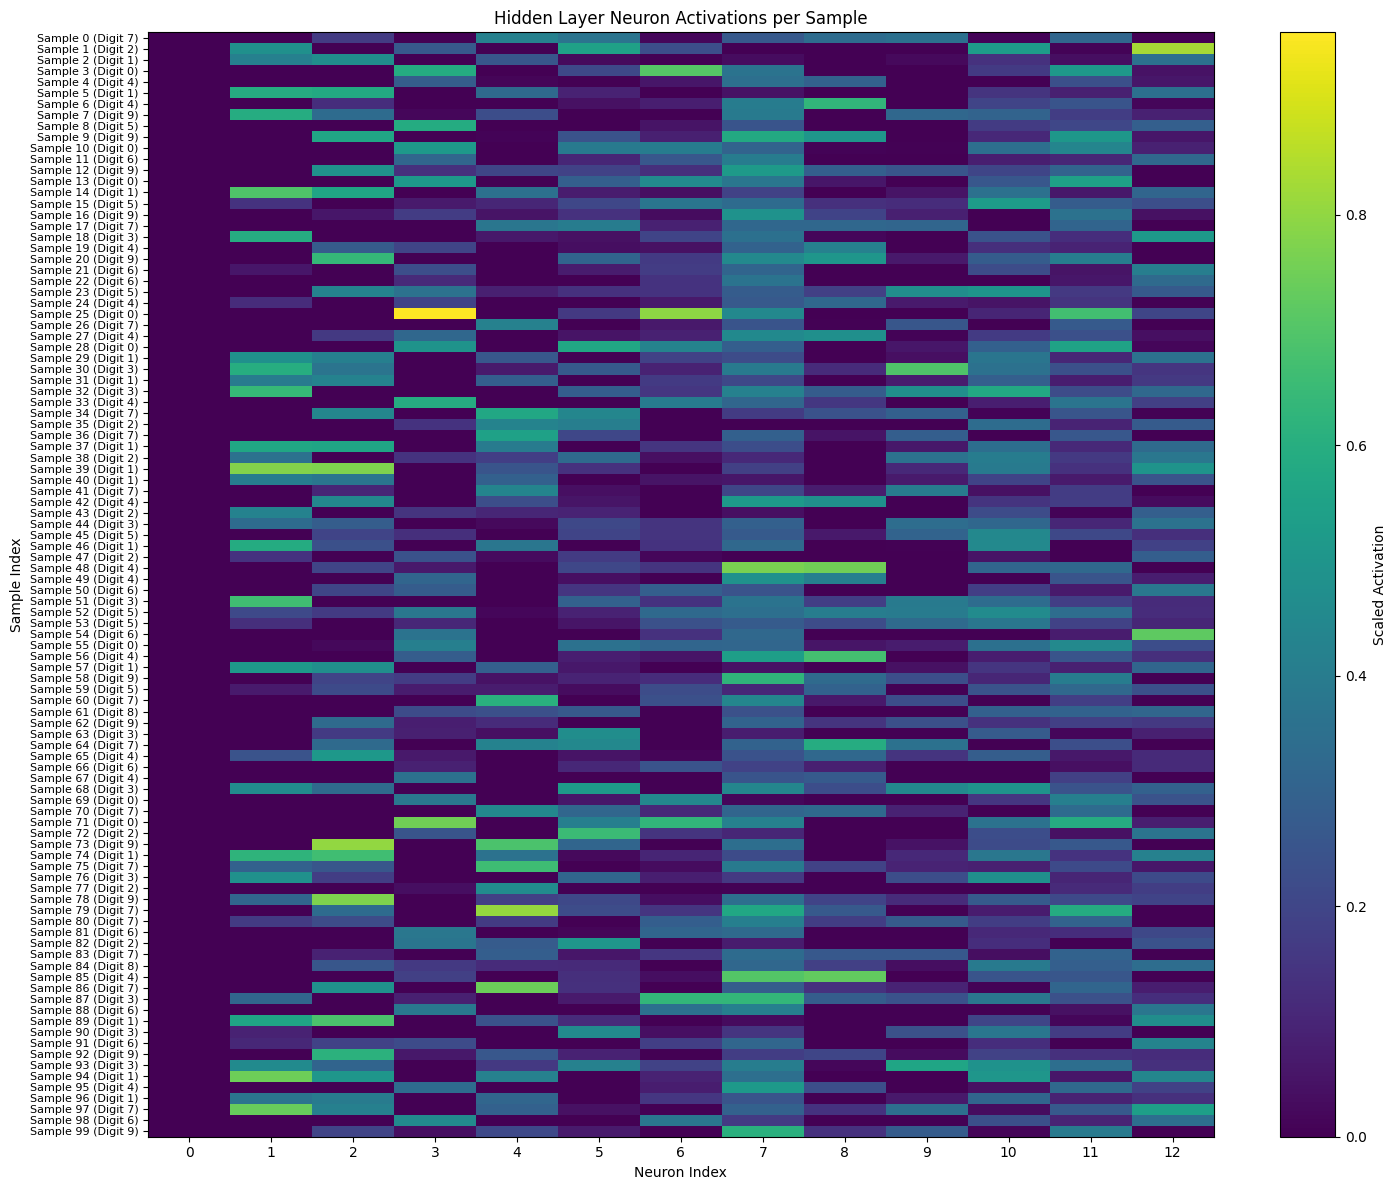


Running evaluation with masked neurons...

Test set with only neurons [7, 10, 11] active:
Average loss: 5.4408, Accuracy: 1718/10000 (17.18%)



In [104]:
# Model with 13 nodes within the hidden layer
model13 = SimpleANN(13, 0.001).to(device)

try:
    if TRAIN_FROM_SCRATCH:
        print("Training new model from scratch...")
        train_model(model13, "13")
    else:
        load_model_and_evaluate(model13, "13")

    # Plot the heatmap after either training or loading
    plot_activation_heatmap(model13)

    # Run evaluation with only neurons X, X, X active
    print("\nRunning evaluation with masked neurons...")
    test_with_masked_neurons(model13, test_loader, keep_neurons=[
        7,
        10,
        11
    ])

except FileNotFoundError:
    print("No checkpoint found! Please train the model first by setting TRAIN_FROM_SCRATCH = True")
except Exception as e:
    print(f"An error occurred: {str(e)}")